<h1>Datetime recognizer</h1>
Train a model to recognize any datetimes in a given text string. 

Start with simple iso8601s and then progress to locales, timezones, countries & conventions.


Starting from the Keras autoencoder example.

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'
os.environ['CUDA_HOME'] = '/usr/local/cuda'

In [2]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning to decode localized datetimes from strings
Input: "Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"
or
       "Monday, 24 October 1977 at 09:10:55 Greenwich Mean Time"
Output: "2007-12-31T07:07:07.00000+02:00"
Padding is handled by using a repeated sentinel character (space)


Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

'''
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
#from keras.callbacks import ReduceLROnPlateau
import numpy as np
from six.moves import range
import pytz
from datetime import datetime, timezone
import itertools
import random
from babel import Locale, localedata, UnknownLocaleError
from babel.dates import format_datetime
from tqdm import tqdm
import sys
import string

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import math

In [4]:
%matplotlib inline

In [5]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, country_codes, maxlen):
        self.chars = set(string.ascii_letters + 
                         string.punctuation + 
                         string.digits
                        )

        ts_from = int(datetime(1980, 1, 1, tzinfo=timezone.utc).timestamp())
        ts_to   = int(datetime(1981, 1, 1, tzinfo=timezone.utc).timestamp())
        tstamps = [t for t in range(ts_from, ts_to, 60*1000)]
        retries = 0
        
        #Hoover up all the non-ascii characters that might be needed
        for country_code in tqdm(country_codes):
            try:                            
                if pytz.country_timezones.get(country_code):
                    for ctzone in pytz.country_timezones(country_code):
                        tzone = pytz.timezone(ctzone)
                        country_locale = Locale.parse('und_' + country_code)
                        for fmt  in ['short',' medium','long','full']:
                            ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=tzone) for t in tstamps]
                            if random.choice([True, False]):
                                X = [format_datetime(dt, format=fmt, locale=country_locale) for dt in ydts]
                            else:
                                sep = random.choice([' ','T'])
                                X = [dt.isoformat(sep) for dt in ydts]

                            # So that's a years worth of datetimes for all the countrys & locales & timezones 
                            for ln in X:
                                # Going with case sensitive because some dt formats have an "i"
                                self.chars = self.chars.union( set(iter(ln)))
                                
            except UnknownLocaleError:                    
                if retries >=21:
                    raise # Somethings gone wrong!

        self.chars = sorted(self.chars)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C[:maxlen]):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [6]:
#ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)
#ctable.chars

In [7]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [8]:
def DateTimeDataGenerator(sample_size):   
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = [random.randrange(0xFFFFFFFF) for _ in range(sample_size)]

        yield tstamps


In [9]:
def DateTimeIsoGenerator(country_codes, sample_size, maxlen_x, maxlen_y, invert):
    """Simplest case for training, straing 86012, no timezone.
    """
    dtdg = DateTimeDataGenerator(sample_size)
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)

        ydts = [datetime.utcfromtimestamp(t).isoformat('T') for t in tstamps]
        sep = random.choice([' ','T'])
        X = [datetime.utcfromtimestamp(t).isoformat(sep) for t in tstamps] 

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
        
        if invert:
            X = [xx[::-1] for xx in X]
            
        yield (X, ydts)

In [10]:
def DateTimeFormattedGenerator(country_codes, sample_size, maxlen_x, maxlen_y, invert):
    dtdg = DateTimeDataGenerator(sample_size)
    all_locales = localedata.locale_identifiers()
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)

        # Pick a country and timezone
        for retries in range(32):
            try:
                country_code = random.choice(country_codes)
                timezone = pytz.timezone(random.choice(pytz.country_timezones(country_code)))
                country_locale = Locale.parse('und_' + country_code)
                break
            except UnknownLocaleError:
                print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
                if retries >=31:
                    raise # Somethings gone wrong!
                    
        ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=timezone).isoformat('T') for t in tstamps]
        

        fmt = random.choice(['short',' medium','long','full'])
        X = [format_datetime(datetime.utcfromtimestamp(t).replace(tzinfo=timezone), 
                             format=fmt, 
                             locale=country_locale
                            ) for t in tstamps]

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
        
        if invert:
            X = [xx[::-1] for xx in X]
            
        yield (X, ydts)

In [11]:
def DateTimeVectorGenerator(dt_generator, ctable):    
    X_next, y_next = next(dt_generator)
    while True:
        # X_next are all the same MAXLEN_X length. Same for y_next
        X = np.zeros((len(X_next), len(X_next[0]), len(ctable.chars)), dtype=np.bool)
        y = np.zeros((len(y_next), len(y_next[0]), len(ctable.chars)), dtype=np.bool)
        
        for i, sentence in enumerate(X_next):
            X[i] = ctable.encode(sentence, len(X_next[0]))
            
        for i, sentence in enumerate(y_next):
            y[i] = ctable.encode(sentence, len(y_next[0]))
        
        yield X, y

In [12]:
def visualize_history(learning_hist, data_filename=None):    
    plt.figure(figsize=(12, 6))
    discard = int(math.ceil(len(learning_hist)/100))*5
    # skip the first few, they destroy plot scale
    plt.plot([i.history['loss']     for i in learning_hist][discard:], label='loss')
    plt.plot([i.history['val_loss'] for i in learning_hist][discard:], label='val_loss')

    plt.ylabel('error')
    plt.xlabel('iteration')
    plt.legend()
    #plt.ylim([0, 0.005])
    plt.title('training error')
    if (data_filename is not None):
        plt.savefig(data_filename)
        plt.close()
    else:
        plt.show()

In [25]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.035
    drop = 0.75
    epochs_drop = 15.0        
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))    
    
    if not epoch % epochs_drop:
        print('Learning rate adjusted: {}'.format(lrate), file=sys.stderr)
    
    return lrate

In [26]:
# Parameters for the model and dataset
TRAINING_SIZE   = 1111 #gn1 #50000
VALIDATION_SIZE = 111
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.SimpleRNN

BATCH_SIZE = 8
LAYERS = 5
MAXLEN_X = 72 # longer than anything expected like 'Monday 31 December 2000 07:07:07.0000000 +02:00 CET/Europe'
MAXLEN_Y = len(datetime.now().isoformat(' '))
COUNTRY_CODES = ['GB', ] #'US','DE','FR','ES','IT','CA', 'NO','SE','DK','FI','EE','CZ','PL'] # pytz.country_names.keys()

HIDDEN_SIZE = MAXLEN_X * 9

In [27]:
ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)

100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


In [28]:
gen_dt = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
#gen_dt = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

gen_vec_train      = DateTimeVectorGenerator(gen_dt, ctable)
gen_vec_validation = DateTimeVectorGenerator(gen_dt, ctable)

X_train, y_train = next(gen_vec_train)
print('X_train.shape: %s'%str(X_train.shape))
print('y_train.shape: %s'%str(y_train.shape))

X_train.shape: (1111, 72, 95)
y_train.shape: (1111, 26, 95)


In [35]:
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use inputhttps://scherbatsky.local:8000/notebooks/ml/datetime%20autoencoder-Copy1.ipynb#_shape=(None, nb_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN_X, len(ctable.chars))))
model.add(Activation('relu'))
#model.add(Dropout(0.2))
# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(MAXLEN_Y))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(ctable.chars))))
model.add(Activation('softmax'))
#opt = RMSprop(lr=0.035, decay=0.999)
#opt = Nadam(lr=0.0035)
#opt = Nadam()
#opt = SGD(lr=0.065, decay=0.999)
opt = SGD(lr=0) # Using scheduler
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
simplernn_9 (SimpleRNN)          (None, 648)           482112      simplernn_input_3[0][0]          
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 648)           0           simplernn_9[0][0]                
____________________________________________________________________________________________________
repeatvector_3 (RepeatVector)    (None, 26, 648)       0           activation_4[0][0]               
____________________________________________________________________________________________________
simplernn_10 (SimpleRNN)         (None, 26, 648)       840456      repeatvector_3[0][0]             
____________________________________________________________________________

In [36]:
stopper = EarlyStopping(patience=25, 
                        verbose=1, 
                        mode='auto')

In [37]:
checkpointer = ModelCheckpoint('../models/checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

In [38]:
learning_hist = []
gen_dt_test = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
#gen_dt_test = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

gen_vec_test = DateTimeVectorGenerator(gen_dt_test, ctable)

X_test, y_test = next(gen_vec_test)

In [39]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate, checkpointer, ]

--------------------------------------------------
Iteration 1


Learning rate adjusted: 0.035


Epoch 1/100
69993/69993 [==============================] - 52s - loss: 2.6330 - acc: 0.3336 - val_loss: 1.5461 - val_acc: 0.6067
Epoch 2/100
69993/69993 [==============================] - 52s - loss: 1.1543 - acc: 0.5856 - val_loss: 0.9481 - val_acc: 0.6188
Epoch 3/100
69993/69993 [==============================] - 51s - loss: 0.9190 - acc: 0.6314 - val_loss: 0.9230 - val_acc: 0.6209
Epoch 4/100
69993/69993 [==============================] - 52s - loss: 0.9022 - acc: 0.6358 - val_loss: 0.9095 - val_acc: 0.6320
Epoch 5/100
69993/69993 [==============================] - 52s - loss: 0.8865 - acc: 0.6477 - val_loss: 0.8995 - val_acc: 0.6511
Epoch 6/100
69993/69993 [==============================] - 51s - loss: 1.4643 - acc: 0.5739 - val_loss: 2.1702 - val_acc: 0.3080
Epoch 7/100
69993/69993 [==============================] - 51s - loss: 1.2680 - acc: 0.5433 - val_loss: 0.9368 - val_acc: 0.6171
Epoch 8/100
69993/69993 [==============================] - 51s - loss: 0.9040 - acc: 0.6377 - val

Learning rate adjusted: 0.026250000000000002


69993/69993 [==============================] - 52s - loss: 0.7238 - acc: 0.7795 - val_loss: 0.5762 - val_acc: 0.8285
Epoch 17/100
69993/69993 [==============================] - 52s - loss: 0.4656 - acc: 0.8716 - val_loss: 0.4714 - val_acc: 0.8600
Epoch 18/100
69993/69993 [==============================] - 52s - loss: 0.3829 - acc: 0.8975 - val_loss: 0.3608 - val_acc: 0.9054
Epoch 19/100
69993/69993 [==============================] - 52s - loss: 0.2966 - acc: 0.9289 - val_loss: 0.2884 - val_acc: 0.9272
Epoch 20/100
69993/69993 [==============================] - 52s - loss: 0.2086 - acc: 0.9598 - val_loss: 0.2422 - val_acc: 0.9397
Epoch 21/100
69993/69993 [==============================] - 52s - loss: 0.1453 - acc: 0.9792 - val_loss: 0.1550 - val_acc: 0.9761
Epoch 22/100
69993/69993 [==============================] - 52s - loss: 0.0874 - acc: 0.9949 - val_loss: 0.1115 - val_acc: 0.9861
Epoch 23/100
69993/69993 [==============================] - 52s - loss: 0.0582 - acc: 0.9990 - val_loss

Learning rate adjusted: 0.019687500000000004


69993/69993 [==============================] - 52s - loss: 0.0123 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9958
Epoch 32/100
69993/69993 [==============================] - 52s - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9958
Epoch 33/100
69993/69993 [==============================] - 52s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9962
Epoch 34/100
69993/69993 [==============================] - 52s - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9969
Epoch 35/100
69993/69993 [==============================] - 52s - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9972
Epoch 36/100
69993/69993 [==============================] - 52s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9979
Epoch 37/100
69993/69993 [==============================] - 52s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9979
Epoch 38/100
69993/69993 [==============================] - 52s - loss: 0.0074 - acc: 1.0000 - val_loss

Learning rate adjusted: 0.014765625000000001


69993/69993 [==============================] - 52s - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9986
Epoch 47/100
69993/69993 [==============================] - 52s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9986
Epoch 48/100
69993/69993 [==============================] - 52s - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9990
Epoch 49/100
69993/69993 [==============================] - 52s - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9990
Epoch 50/100
69993/69993 [==============================] - 52s - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0176 - val_acc: 0.9990
Epoch 51/100
69993/69993 [==============================] - 52s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9990
Epoch 52/100
69993/69993 [==============================] - 52s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 0.9990
Epoch 53/100
69993/69993 [==============================] - 52s - loss: 0.0041 - acc: 1.0000 - val_loss

Learning rate adjusted: 0.011074218750000002


69993/69993 [==============================] - 52s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9990
Epoch 62/100
69993/69993 [==============================] - 52s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9990
Epoch 63/100
69993/69993 [==============================] - 52s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9990
Epoch 64/100
69993/69993 [==============================] - 52s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9990
Epoch 65/100
69993/69993 [==============================] - 52s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9990
Epoch 66/100
69993/69993 [==============================] - 52s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9990
Epoch 67/100
69993/69993 [==============================] - 52s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9990
Epoch 68/100
69993/69993 [==============================] - 52s - loss: 0.0030 - acc: 1.0000 - val_loss

Learning rate adjusted: 0.0083056640625


69993/69993 [==============================] - 52s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9990
Epoch 77/100
69993/69993 [==============================] - 52s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9990
Epoch 78/100
69993/69993 [==============================] - 52s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9990
Epoch 79/100
69993/69993 [==============================] - 52s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9990
Epoch 80/100
69993/69993 [==============================] - 52s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9990
Epoch 81/100
69993/69993 [==============================] - 52s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.9990
Epoch 82/100
69993/69993 [==============================] - 52s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9990
Epoch 83/100
69993/69993 [==============================] - 52s - loss: 0.0025 - acc: 1.0000 - val_loss

Learning rate adjusted: 0.006229248046875001


69993/69993 [==============================] - 52s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 0.9990
Epoch 92/100
69993/69993 [==============================] - 52s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9990
Epoch 93/100
69993/69993 [==============================] - 52s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9990
Epoch 94/100
69993/69993 [==============================] - 52s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 0.9990
Epoch 95/100
69993/69993 [==============================] - 52s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 0.9990
Epoch 96/100
69993/69993 [==============================] - 52s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 0.9990
Epoch 97/100
69993/69993 [==============================] - 52s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 0.9990
Epoch 98/100
69993/69993 [==============================] - 52s - loss: 0.0022 - acc: 1.0000 - val_loss

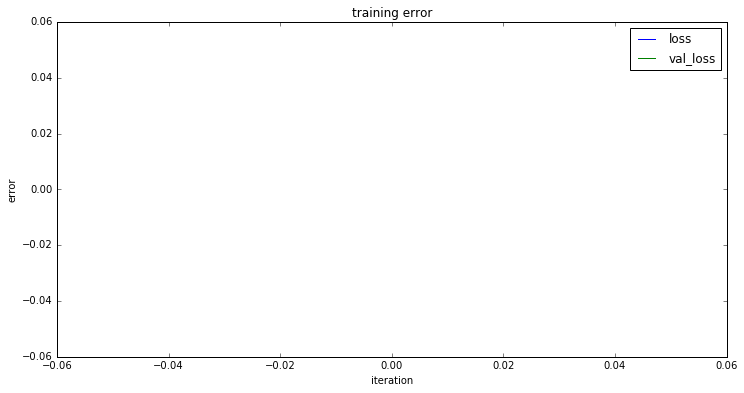

In [40]:
# Train the model each generation and show predictions against the validation dataset

for iteration in range(1, 1+1):
    print('-' * 50)
    print('Iteration', iteration)
    
    # switch locale (probably)
    gen_dt_train = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)  
    gen_dt_val   = DateTimeIsoGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
    ## or
    #gen_dt_train = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
    #gen_dt_val   = DateTimeFormattedGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

    gen_vec_train      = DateTimeVectorGenerator(gen_dt_train, ctable)
    gen_vec_validation = DateTimeVectorGenerator(gen_dt_val,   ctable)
    
    learning_hist.append(
            model.fit_generator( gen_vec_train, 
                                samples_per_epoch=69993, #88880, #, 
                                nb_epoch=100, 
                                verbose=1, 
                                callbacks=callbacks_list, 
                                validation_data=gen_vec_validation, 
                                nb_val_samples=VALIDATION_SIZE, 
                                #class_weight={}, 
                                #max_q_size=10, 
                                #nb_worker=1, 
                                #pickle_safe=False
                               )
            )
    ###
    # Select 3 samples from the test set so we can visualize errors
    if iteration % 5 == 0:
        model.save('../models/datatime_autoencoder_model.h5')
        for i in range(3):
            X_test, y_test = next(gen_vec_test)            
            preds = model.predict_classes(X_test, verbose=0)
            q = ctable.decode(X_test[0])
            correct = ctable.decode(y_test[0])
            guess = ctable.decode(preds[0], calc_argmax=False)
            print('Q', q[::-1] if INVERT else q )
            print('T', correct)
            print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

visualize_history(learning_hist)            

In [23]:
#!! rm ../models/checkpoint.*

In [24]:
Bumped lr=0.05, nb_epoch=1,  576(72*8) Hidden, iterations=50, Relu

SyntaxError: invalid syntax (<ipython-input-24-4475975b321a>, line 1)

<h1>Results</h1>

In [ ]:
--------------------------------------------------
Iteration 151
Epoch 1/1
69993/69993 [==============================] - 35s - loss: 0.7406 - acc: 0.7026 - val_loss: 0.7502 - val_acc: 0.7017

In [ ]:
--------------------------------------------------
Iteration 125
Epoch 1/1
69993/69993 [==============================] - 35s - loss: 1.5492 - acc: 0.5519 - val_loss: 1.5425 - val_acc: 0.5606
Q 2012-02-14T07:26:58                                                     
T 2012-02-14T07:26:58       
☒ 2090-01-0000:::::         
Q 2012-02-14T07:26:58                                                     
T 2012-02-14T07:26:58       
☒ 2090-01-0000:::::         
Q 2012-02-14T07:26:58                                                     
T 2012-02-14T07:26:58       
☒ 2090-01-0000:::::   

In [ ]:
------------sgd hidden*5--------------------------------------
Iteration 50
Epoch 1/1
69993/69993 [==============================] - 19s - loss: 1.6622 - acc: 0.5932 - val_loss: 1.6589 - val_acc: 0.5925
Q 2042-10-15 00:45:32                                                     
T 2042-10-15T00:45:32       
☒ 2000-00-01T11::::         
Q 2042-10-15 00:45:32                                                     
T 2042-10-15T00:45:32       
☒ 2000-00-01T11::::         
Q 2042-10-15 00:45:32                                                     
T 2042-10-15T00:45:32       
☒ 2000-00-01T11:::: 

In [ ]:
Iteration 50
Epoch 1/1
69993/69993 [==============================] - 57s - loss: 1.3140 - acc: 0.5820 - val_loss: 1.3093 - val_acc: 0.5811
Q 2045-04-22T12:16:56                                                     
T 2045-04-22T12:16:56       
☒ 200--00--1TT:::::::       
Q 2045-04-22T12:16:56                                                     
T 2045-04-22T12:16:56       
☒ 200--00--1TT:::::::       
Q 2045-04-22T12:16:56                                                     
T 2045-04-22T12:16:56       
☒ 200--00--1TT:::::::

<h2>2 Layer, Relu, lr=0.01, 360(72*5) Hidden, ISO8601</h2>
~~~
Iteration 60
Epoch 1/1
69993/69993 [==============================] - 38s - loss: 0.7598 - acc: 0.7147 - val_loss: 0.7792 - val_acc: 0.7100
Q 2082-12-26 01:57:13                                                     
T 2082-12-26T01:57:13       
☒ 2022-12-22T12:22:12       
Q 2082-12-26 01:57:13                                                     
T 2082-12-26T01:57:13       
☒ 2022-12-22T12:22:12       
Q 2082-12-26 01:57:13                                                     
T 2082-12-26T01:57:13       
☒ 2022-12-22T12:22:12
~~~

<h2>2 Layer Adam, 333 Hidden, ISO8601</h2>
~~~
Iteration 20
Epoch 1/1
69993/69993 [==============================] - 41s - loss: 1.9638 - acc: 0.3964 - val_loss: 1.9701 - val_acc: 0.3957
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000              
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000              
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000 
~~~

<h2>3 Layer, Adam, 333 hidden, ISO8601</h2>
~~~
Iteration 200
Epoch 1/1
46662/46662 [==============================] - 32s - loss: 0.5656 - acc: 0.7843 - val_loss: 0.5589 - val_acc: 0.7904
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57       
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57       
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57     
~~~

In [47]:
X_test, y_test = next(gen_vec_test)            
preds = model.predict_classes(X_test, verbose=0)
q = ctable.decode(X_test[0])
correct = ctable.decode(y_test[0])
guess = ctable.decode(preds[0], calc_argmax=False)
print('Q', q[::-1] if INVERT else q )
print('T', correct)
print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

Q 2035-06-25T19:58:17                                                     
T 2035-06-25T19:58:17       
☑ 2035-06-25T19:58:17       


In [ ]:
len(learning_hist[0].history['loss'])

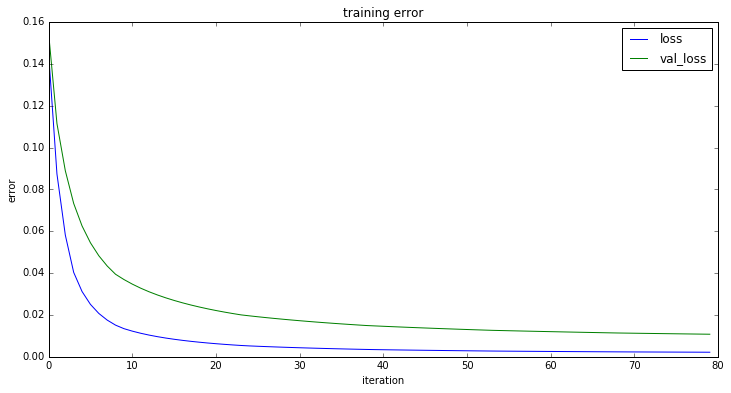

In [42]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*20
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training error')
plt.show()

In [ ]:
len(learning_hist[0].history['loss'])

In [ ]:
model.save('../models/datatime_autoencoder_model.h5')